In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imagehash import phash
from tqdm import tqdm_notebook as tqdm

In [3]:
TRAIN_DF = '/home/data/whale/train.csv'
SUB_Df = '/home/data/whale/sample_submission.csv'
TRAIN = '/home/data/whale/train/'
TEST = '/home/data/whale/test/'
#P2H = '/home/data/whale/p2h.pickle'
#P2SIZE = '/home/data/whale/p2size.pickle'
BB_DF = '/home/data/whale/bounding_boxes.csv'

In [8]:
tagged = dict([(p, w) for _, p, w in pd.read_csv(TRAIN_DF).to_records()])
submit = [p for _, p, _ in pd.read_csv(SUB_Df).to_records()]
all_pic = list(tagged.keys()) + submit

In [10]:
def expand_path(p):
    if os.path.isfile(TRAIN + p):
        return TRAIN + p
    if os.path.isfile(TEST + p):
        return TEST + p
    return p

from PIL import Image as pil_image
p2size = {}
for p in tqdm(all_pic):
    size = pil_image.open(expand_path(p)).size
    p2size[p] = size

In [12]:
def match(h1, h2):
    for p1 in h2ps[h1]:
        for p2 in h2ps[h2]:
            i1 = pil_image.open(expand_path(p1))
            i2 = pil_image.open(expand_path(p2))
            if i1.mode != i2.mode or i1.size != i2.size: return False
            a1 = np.array(i1)
            a1 = a1 - a1.mean()
            a1 = a1 / sqrt((a1 ** 2).mean())
            a2 = np.array(i2)
            a2 = a2 - a2.mean()
            a2 = a2 / sqrt((a2 ** 2).mean())
            a = ((a1 - a2) ** 2).mean()
            if a > 0.1: return False
    return True

# Compute phash for each image in the training and test set.
p2h = {}
for p in tqdm(all_pic):
    img = pil_image.open(expand_path(p))
    h = phash(img)
    p2h[p] = h

# Find all images associated with a given phash value.
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)

In [32]:
from math import sqrt
# Find all distinct phash values
hs = list(h2ps.keys())

# If the images are close enough, associate the two phash values (this is the slow part: n^2 algorithm)
h2h = {}
for i, h1 in enumerate(tqdm(hs)):
    for h2 in hs[:i]:
        if h1 - h2 <= 6 and match(h1, h2):
            s1 = str(h1)
            s2 = str(h2)
            if s1 < s2: s1, s2 = s2, s1
            h2h[s1] = s2

# Group together images with equivalent phash, and replace by string format of phash (faster and more readable)
for p, h in p2h.items():
    h = str(h)
    if h in h2h: h = h2h[h]
    p2h[p] = h
#with open(P2H, 'wb') as f:
#    pickle.dump(p2h, f)
# For each image id, determine the list of pictures
h2ps = {}
for p, h in p2h.items():
    if h not in h2ps: h2ps[h] = []
    if p not in h2ps[h]: h2ps[h].append(p)

In [37]:
def show_whale(imgs, per_row=2):
    n = len(imgs)
    rows = (n + per_row - 1) // per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows, cols, figsize=(24 // per_row * cols, 24 // per_row * rows))
    for ax in axes.flatten(): ax.axis('off')
    for i, (img, ax) in enumerate(zip(imgs, axes.flatten())): ax.imshow(img.convert('RGB'))
        

def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img

In [38]:
# For each images id, select the prefered image
def prefer(ps):
    if len(ps) == 1: return ps[0]
    best_p = ps[0]
    best_s = p2size[best_p]
    for i in range(1, len(ps)):
        p = ps[i]
        s = p2size[p]
        if s[0] * s[1] > best_s[0] * best_s[1]:  # Select the image with highest resolution
            best_p = p
            best_s = s
    return best_p

h2p = {}
for h, ps in h2ps.items():
    h2p[h] = prefer(ps)
len(h2p), list(h2p.items())[:5]

(33317,
 [('d26698c3271c757c', '0000e88ab.jpg'),
  ('ba8cc231ad489b77', '0001f9222.jpg'),
  ('bbcad234a52d0f0b', '00029d126.jpg'),
  ('c09ae7dc09f33a29', '00050a15a.jpg'),
  ('d02f65ba9f74a08a', '0005c1ef8.jpg')])

In [54]:
for h, ws in h2ps.items():
    if len(ws) > 1:
        print(ws)

['01f66ca26.jpg', 'd37179fd1.jpg']
['579886448.jpg', 'f50529c53.jpg']
['60a3f2422.jpg', '7f7a63b8a.jpg']
['b95d73a55.jpg', 'fb3879dc7.jpg']


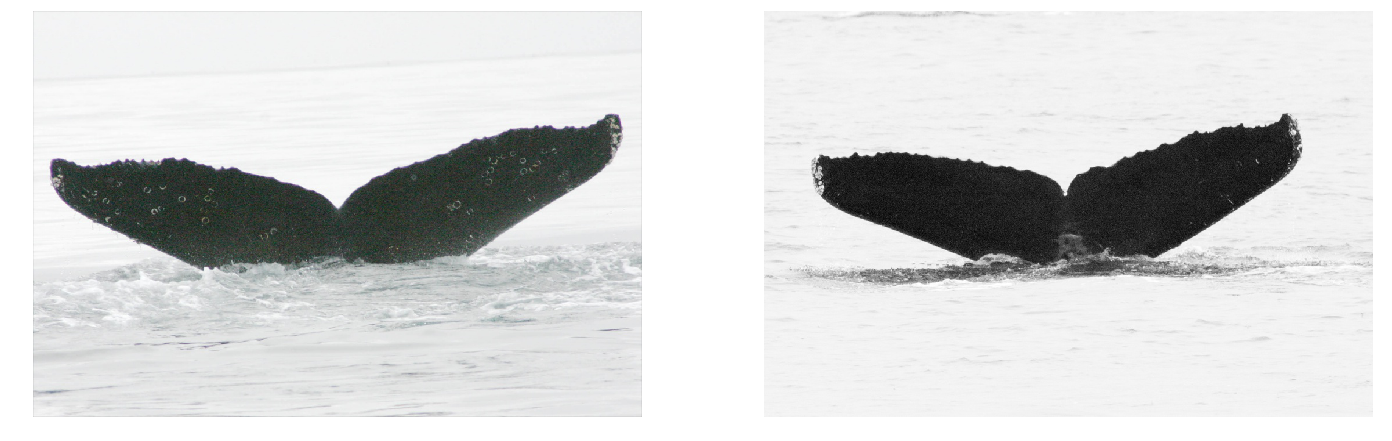

In [71]:
imgs = [pil_image.open(TEST+'d37179fd1.jpg'), pil_image.open(TRAIN+'b95d73a55.jpg')]
show_whale(imgs)

In [47]:
h2ws = {}
new_whale = 'new_whale'
for p, w in tagged.items():
    if w != new_whale:  # Use only identified whales
        h = p2h[p]
        if h not in h2ws: h2ws[h] = []
        if w not in h2ws[h]: h2ws[h].append(w)
for h, ws in h2ws.items():
    if len(ws) > 1:
        h2ws[h] = sorted(ws)

# For each whale, find the unambiguous images ids.
w2hs = {}
for h, ws in h2ws.items():
    if len(ws) == 1:  # Use only unambiguous pictures
        w = ws[0]
        if w not in w2hs: w2hs[w] = []
        if h not in w2hs[w]: w2hs[w].append(h)
for w, hs in w2hs.items():
    if len(hs) > 1:
        w2hs[w] = sorted(hs)

In [77]:
import random
train = [] # A list of training image ids
i = 0
for hs in w2hs.values():
    if len(hs) > 1:
        train += hs
    else:
        i += 1
print('only one pic~', i)
random.shuffle(train)
train_set = set(train)
print(len(train), len(train_set))
w2ts = {}  # Associate the image ids from train to each whale id.
for w, hs in w2hs.items():
    for h in hs:
        if h in train_set:
            if w not in w2ts:
                w2ts[w] = []
            if h not in w2ts[w]:
                w2ts[w].append(h)
for w, ts in w2ts.items():
    w2ts[w] = np.array(ts)

t2i = {}  # The position in train of each training image id
for i, t in enumerate(train):
    t2i[t] = i

only one pic~ 2073
13623 13623


In [80]:
len(t2i)

13623

In [79]:
len(w2hs)

5004